# Mapping the Credit Card Customer Landscape

## Table of Contents

* [Introduction](#introduction)
* [Goal](#goal)
* [Summary](#summary)
* [The Data](#the_data)
* [Feature Engineering](#feature_engineering)
* [Scaling the Data](#scaling_the_data)
* [Choosing K](#choosing_k)
* [Analyzing Results](#analyzing_results)
* [Conclusion](#conclusion)
* [Next Steps](#next_steps)

## Introduction  <a name="introduction"></a>

We're data scientists within a credit card company. We've been asked to help segment customer information into different groups, in order to apply different business strategies for each type of customer.

## Goal  <a name="goal"></a>

The goal of this project is to segment the customer data into distinct, well-defined groups, with clear identifying features for each segment. By the end of the project, we will have a comprehensive understanding of the different customer personas, enabling more targeted and effective marketing, product development, and customer service strategies.

## Summary  <a name="summary"></a>

Our analysis has identified 7 distinct customer profiles within the dataset, differentiated by factors such as gender, age, marital status, income, and spending patterns. 

By deeply understanding these unique customer segments, we can develop tailored strategies to better serve their needs and preferences.

This granular customer intelligence will enable more effective acquisition, retention and relationship-building efforts, helping us adapt to evolving market dynamics over time. 

Moving forward, continued monitoring and refinement of these customer clusters will be crucial to sustaining a competitive edge.

## The Data <a name="the_data"></a>

The following is some boilerplate code that loads the required libraries, reads the data and displays some initial information about it:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
plt.style.use('seaborn-v0_8')

In [4]:
# Reading the file
data = pd.read_csv("customer_segmentation.csv")

In [5]:
data.shape

(10127, 14)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

In [7]:
data.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


The dataset has records of 10,127 customers, each with 13 features (plus `customer_id`, which isn't analyzed).
There are no missing features from any of the records.

The features are as follows:

1. `customer_id`: unique identifier for each customer.
2. `age`: customer age in years.
3. `gender`: customer gender (`M` or `F`).
4. `dependent_count`: number of dependents of each customer.
5. `education_level`: level of education (`High School`, `Graduate`, etc.).
6. `marital_status`: marital status (`Single`, `Married`, etc.).
7. `estimated_income`: the estimated income for the customer projected by the data science team.
8. `months_on_book`: time as a customer in months.
9. `total_relationship_count`: number of times the customer contacted the company.
10. `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months.
11. `credit_limit`: customer's credit limit.
12. `total_trans_amount`: the overall amount of money spent on the card by the customer.
13. `total_trans_count`: the overall number of times the customer used the card.
14. `avg_utilization_ratio`: daily average utilization ratio.

Of the features, 3 are categorical (`gender`, `education_level` and `marital_status`) and the other 10 are numeric.

In [8]:
categorical_features = ['gender', 'education_level', 'marital_status']

for feature in categorical_features:
    print(data[feature].value_counts(), end='\n\n')

gender
F    5358
M    4769
Name: count, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



The categorical data is clean, without typos or irrelevant data.

The gender distribution is relatively balanced, with a slightly higher proportion of males at 53% compared to 47% females.

Let's have a look at the correlation between the different features. We're not measuring against a specific target variable, so we're simply looking for interesting correlations throughout the database:

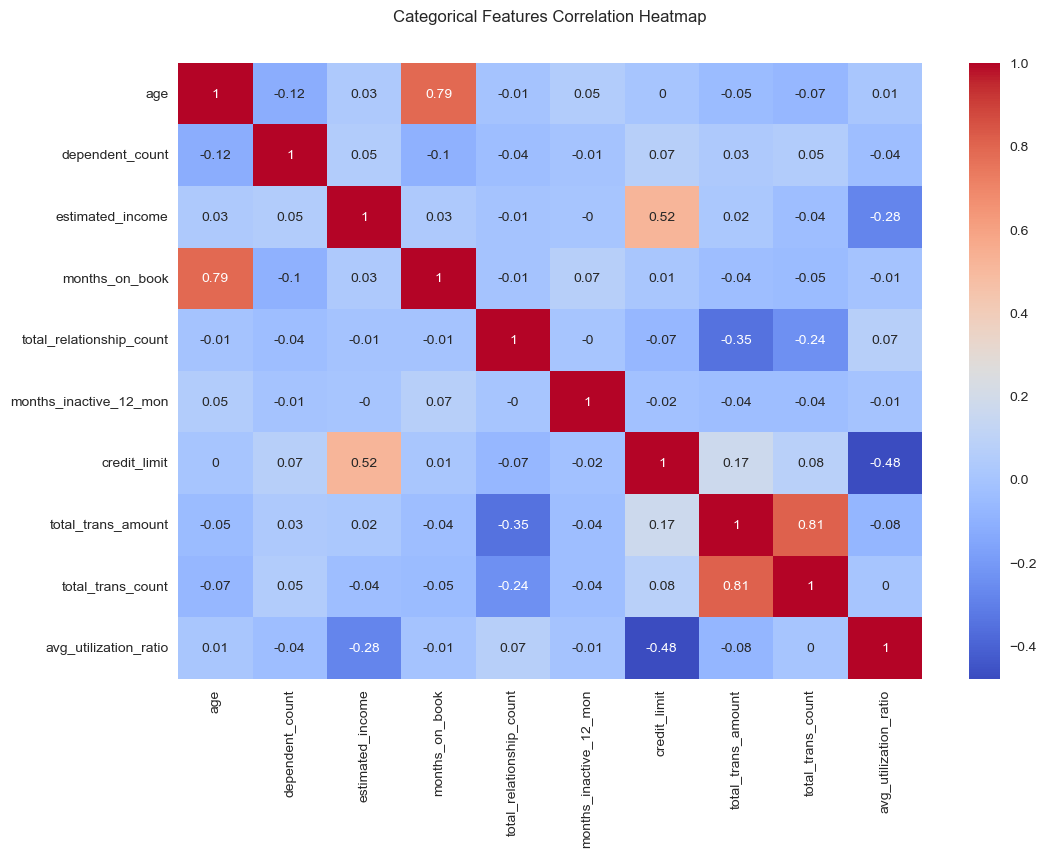

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(round(data.drop(categorical_features + ['customer_id'], axis=1).corr(), 2), cmap='coolwarm', annot=True)

plt.title("Categorical Features Correlation Heatmap", pad=30)
plt.show()

Most of the features show a very small correlation. We can, however, see some correlations that may prove to be interesting:

- `total_trans_amount` and `total_trans_count` are strongly correlated (`0.81`). That sounds reasonable, as it makes sense that the more times a customer has used their card the more money they spent
- `months_on_book` and `age` have a strong correlation, which, again, makes sense. The older a customer is, the more time they had to hold our card
- `credit_limit` is somewhat correlated (`0.52`) with `estimated_income`, and negatively correlated (`-0.48`) with `avg_utilization_ratio`

Next, let's look at the distributions of the numerical features:

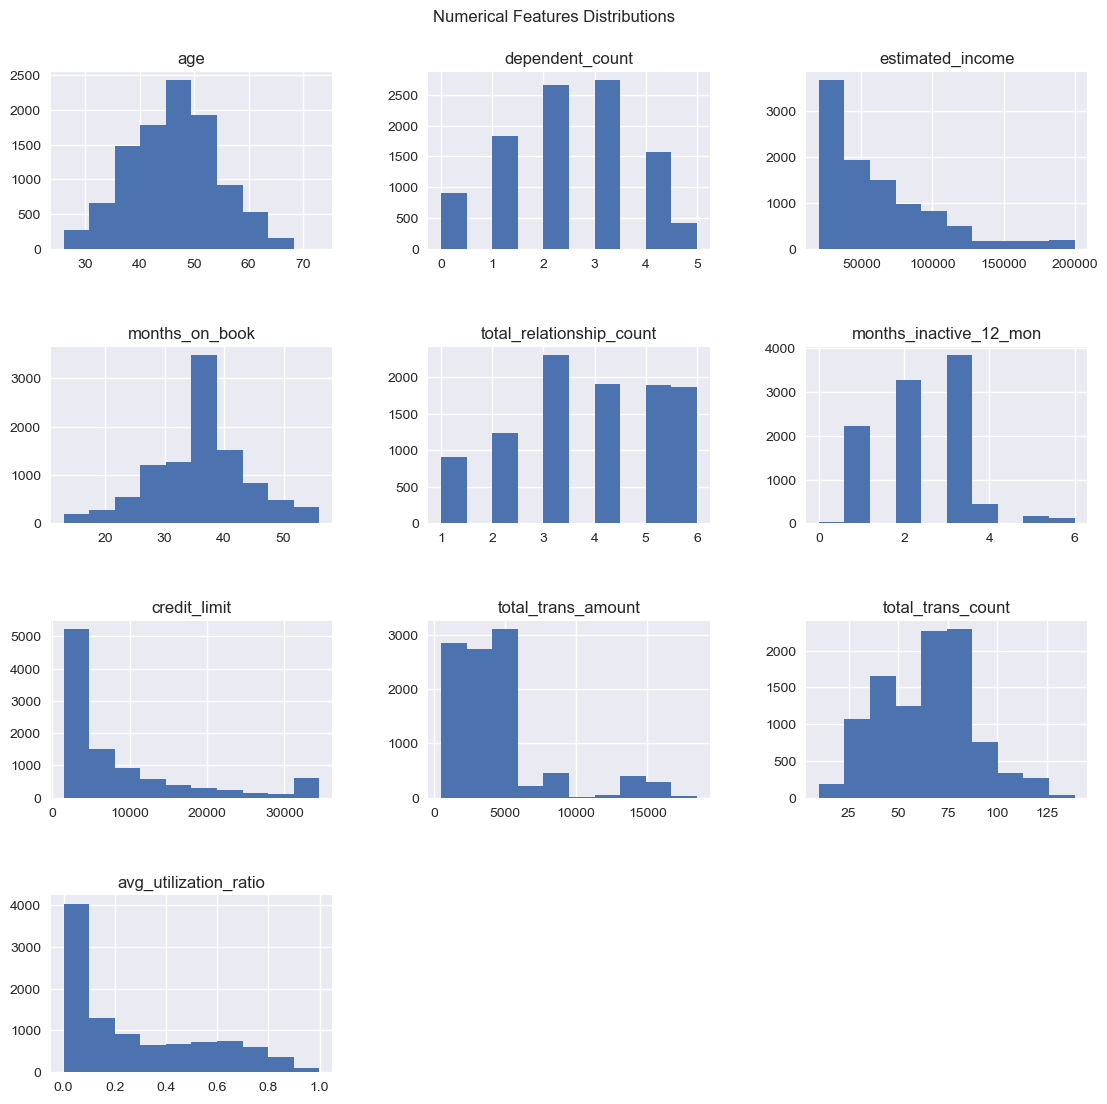

In [20]:
data.drop(categorical_features + ['customer_id'], axis=1).hist(figsize=(12, 12))

plt.suptitle("Numerical Features Distributions")
plt.tight_layout(pad=4.0, rect=[0, 0.03, 1, 1.05])
plt.show()

In [10]:
data.drop('customer_id', axis=1).describe()

,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,62078.206774,35.928409,3.812580,2.341167,8631.953698,4404.086304,64.858695,0.274894
std,8.016814,1.298908,39372.861291,7.986416,1.554408,1.010622,9088.776650,3397.129254,23.472570,0.275691
min,26.000000,0.000000,20000.000000,13.000000,1.000000,0.000000,1438.300000,510.000000,10.000000,0.000000
25%,41.000000,1.000000,32000.000000,31.000000,3.000000,2.000000,2555.000000,2155.500000,45.000000,0.023000
50%,46.000000,2.000000,50000.000000,36.000000,4.000000,2.000000,4549.000000,3899.000000,67.000000,0.176000
75%,52.000000,3.000000,80000.000000,40.000000,5.000000,3.000000,11067.500000,4741.000000,81.000000,0.503000
max,73.000000,5.000000,200000.000000,56.000000,6.000000,6.000000,34516.000000,18484.000000,139.000000,0.999000


Looking at the above histogram plots and table, we can see that:
- There are no glaring outliers
- `estimated_income`, `credit_limit`, `total_trans_amount` and `avg_utilization_ratio` are right-skewed.
- `age`, `months_on_book` and `total_trans_count` are more normally-distributed

## Feature Engineering  <a name="feature_engineering"></a>

In [11]:
# Make a copy of the dataset, before making madifications to it
data_modif = data.copy()

We'll start with replacing the `gender` data with 0/1, to make analysis easier:

In [12]:
data_modif['gender'] = data_modif['gender'].map({'M':1, 'F':0})

Now we'll make a similar replacement for `education_level`:

In [13]:
education_level_to_int = {
    'Uneducated' : 0,
    'High School' : 1,
    'College' : 2,
    'Graduate' : 3,
    'Post-Graduate' : 4,
    'Doctorate' : 5
}

data_modif['education_level'] = data_modif['education_level'].map(education_level_to_int)

As for `marital_status`, there's no objective way to sort the various statuses, so we'll use hot-one-encoding to create dummy variables:

In [14]:
data_modif = pd.get_dummies(data_modif, columns=['marital_status'], dtype=int, drop_first=True)
data_modif

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,1,2,3,51000,40,3,2,4003.0,15476,117,0.462,0,1,0
10123,710638233,41,1,2,3,40000,25,4,2,4277.0,8764,69,0.511,0,0,0
10124,716506083,44,0,1,1,33000,36,5,3,5409.0,10291,60,0.000,1,0,0
10125,717406983,30,1,2,3,47000,36,4,3,5281.0,8395,62,0.000,0,0,1


## Scaling the Data <a name="scaling_the_data"></a>

So that we can work with the data efficiently we need to make sure all the values are scaled similarly.

In [15]:
clean_data = data_modif.drop('customer_id', axis=1).copy()

In [16]:
# Instantiate a new scaler
scaler = StandardScaler()
#fit the dataframe
scaler.fit(clean_data)
#Scale the dataframe
scaled_data = pd.DataFrame(scaler.transform(clean_data), columns=clean_data.columns)
scaled_data

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1.077338,-0.798507,-0.282609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.458314,1.059956,-0.266547,0.662787,-0.281380,0.509840,-0.522785,-0.337598,-0.509330,3.259358,2.221481,0.678714,-0.928214,1.252337,-0.282609
10123,-0.664382,1.059956,-0.266547,0.662787,-0.560775,-1.368442,0.120579,-0.337598,-0.479181,1.283475,0.176440,0.856458,-0.928214,-0.798507,-0.282609
10124,-0.290150,-0.943436,-1.036462,-0.752211,-0.738571,0.008965,0.763943,0.651940,-0.354626,1.732994,-0.207005,-0.997155,1.077338,-0.798507,-0.282609
10125,-2.036565,1.059956,-0.266547,0.662787,-0.382978,0.008965,0.120579,0.651940,-0.368710,1.174848,-0.121795,-0.997155,-0.928214,-0.798507,3.538459


## Choosing K <a name="choosing_k"></a>

Ther dataset i nows ready for machine learning. The next step is to decide the best number of clusters to use in the segmentation according to the inertia metric
We'll create several models and compute the inertia from each of them. them we'll be able to plot the Elbow Curve and decide the number of clusters we'll use to segment the customers. Once we do all that we can perform the real clusterization..

In [46]:
inertias = []
for i in range(1, 11):
    model = KMeans(n_clusters = i)
    model.fit_predict(scaled_data)
    inertias.append(model.inertia_)

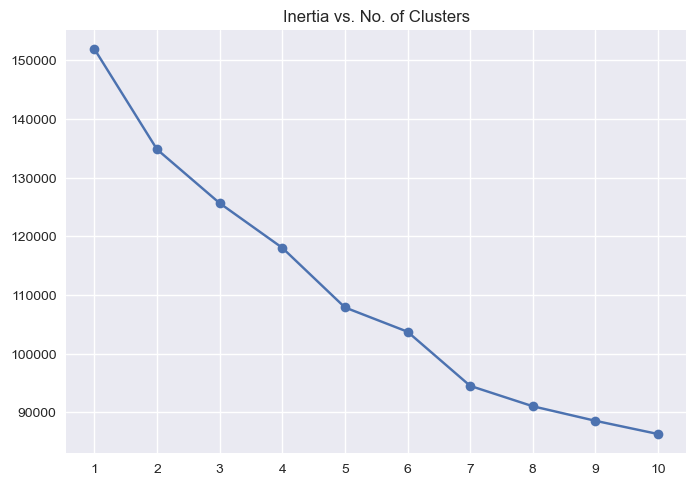

In [47]:
plt.plot(range(1, 11), inertias, marker='o')
plt.title("Inertia vs. No. of Clusters")
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.show()

Since there's no clear elbow, let's look at the percent decrease in inertia to try and find a good candidate:

In [48]:
percent_decrease = [(1 - (inertias[i] / inertias[i - 1])) * 100 for i in range(1, 10)]

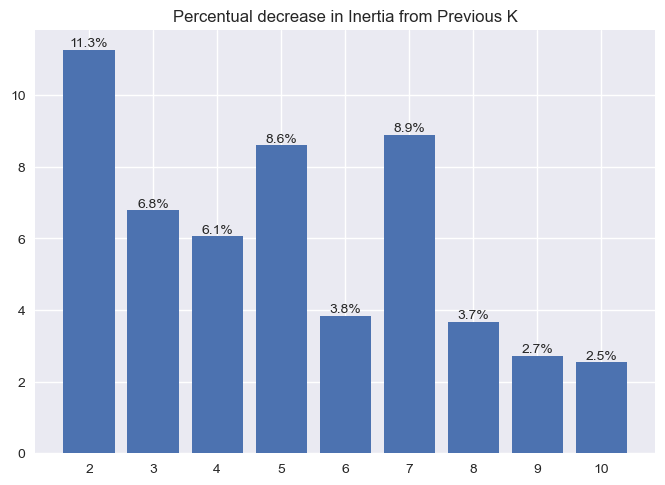

In [49]:
ax = plt.bar(range(2, 11), percent_decrease)
plt.bar_label(ax, fmt='%.1f%%')
plt.title("Percentual decrease in Inertia from Previous K")
plt.xticks(ticks=range(2, 11), labels=range(2, 11))
plt.show()

The differences in the percentage decrease of inertia between successive cluster counts are not extremely large, suggesting there is no clearly dominant elbow point. However, the decrease in inertia from 7 clusters to 8 clusters is more than 50% smaller than the decreases in the preceding steps. This significant drop in the rate of decrease indicates that the 7 cluster solution provides a good balance between model complexity and explanatory power.

In [55]:
model = KMeans(n_clusters = 7)
clusters = model.fit_predict(scaled_data)

## Analyzing Results <a name="analyzing_results"></a>

All that's left now is to analyze the results. We need to see how the variables used in the clusterization differ from cluster to cluster in order better explain what each cluster represents.
Let's find the main characteristics of each cluster and how they can impact the business and marketing strategies for each type of customer:

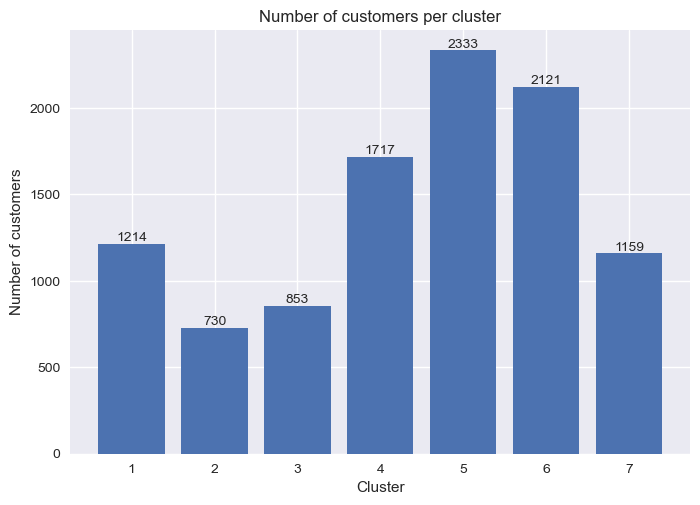

In [56]:
data['CLUSTER'] = clusters + 1
ax = plt.bar(range(1, 8), data['CLUSTER'].value_counts().sort_index())
plt.title("Number of customers per cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of customers")
plt.bar_label(ax)
plt.show()

We have 3 larger clusters (4, 5 and 6) and 4 smaller ones, with 2 being the smallest cluster with only 730 customers.

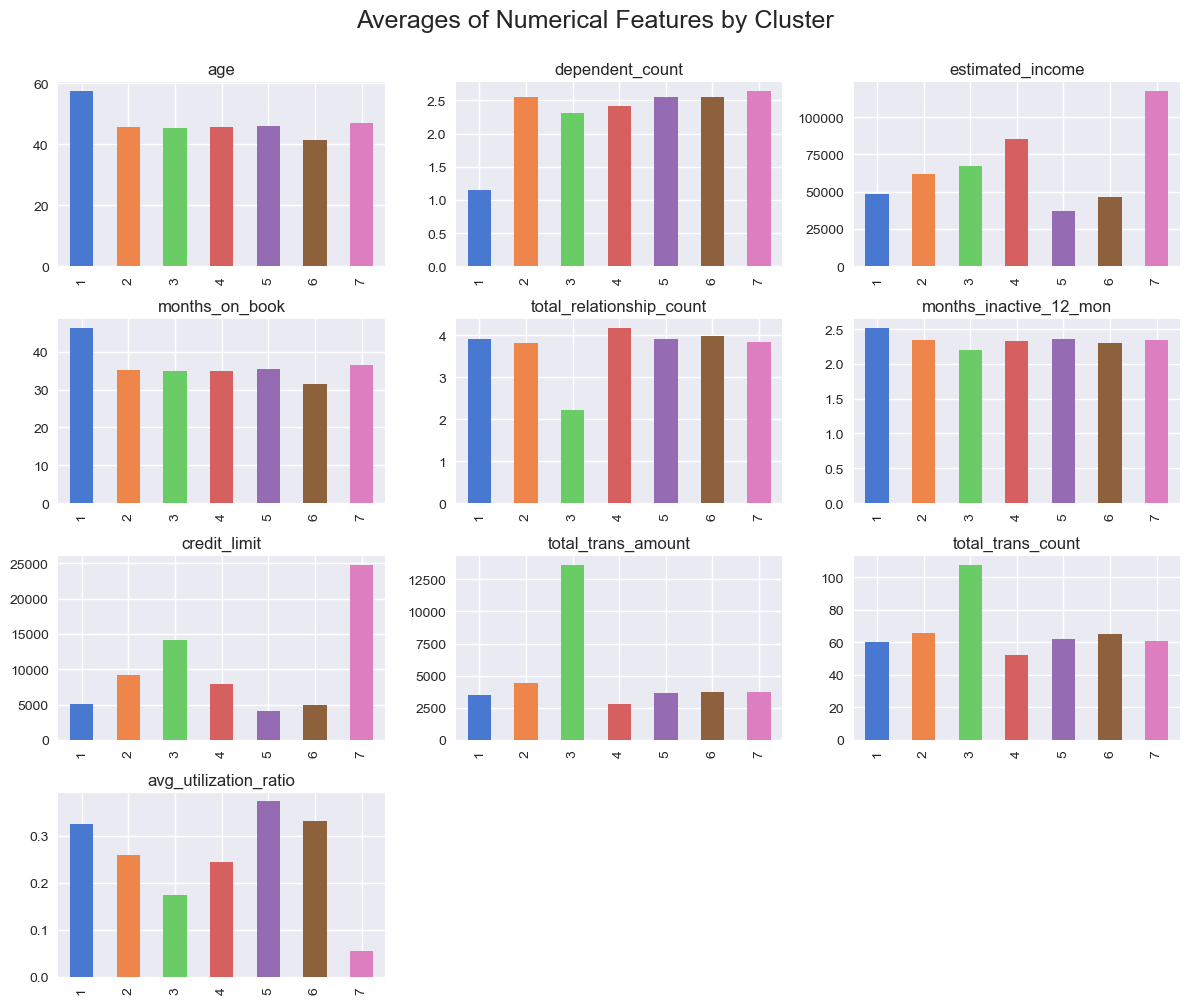

In [57]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Averages of Numerical Features by Cluster", fontsize=18, y=1.0)

numeric_features = data.drop(categorical_features + ['customer_id', 'CLUSTER'], axis=1).columns
    
# set number of columns
ncols = 3
# calculate number of rows
nrows = len(numeric_features) // ncols + (len(numeric_features) % ncols > 0)

# loop through the length of numeric_features and keep track of index
for i, feature in enumerate(numeric_features):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, i + 1)

    # group the data by clusters and plot the feature on the new subplot axis
    data.groupby('CLUSTER')[feature].mean().plot.bar(ax=ax, figsize=(12, 10), color=sns.color_palette('muted'))

    # chart formatting
    ax.set_title(feature)
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

We can now look at the more highly correlated numerical features. We'll create scatter plots for each pair and colour the data points by cluster to see if we can identify some patterns.

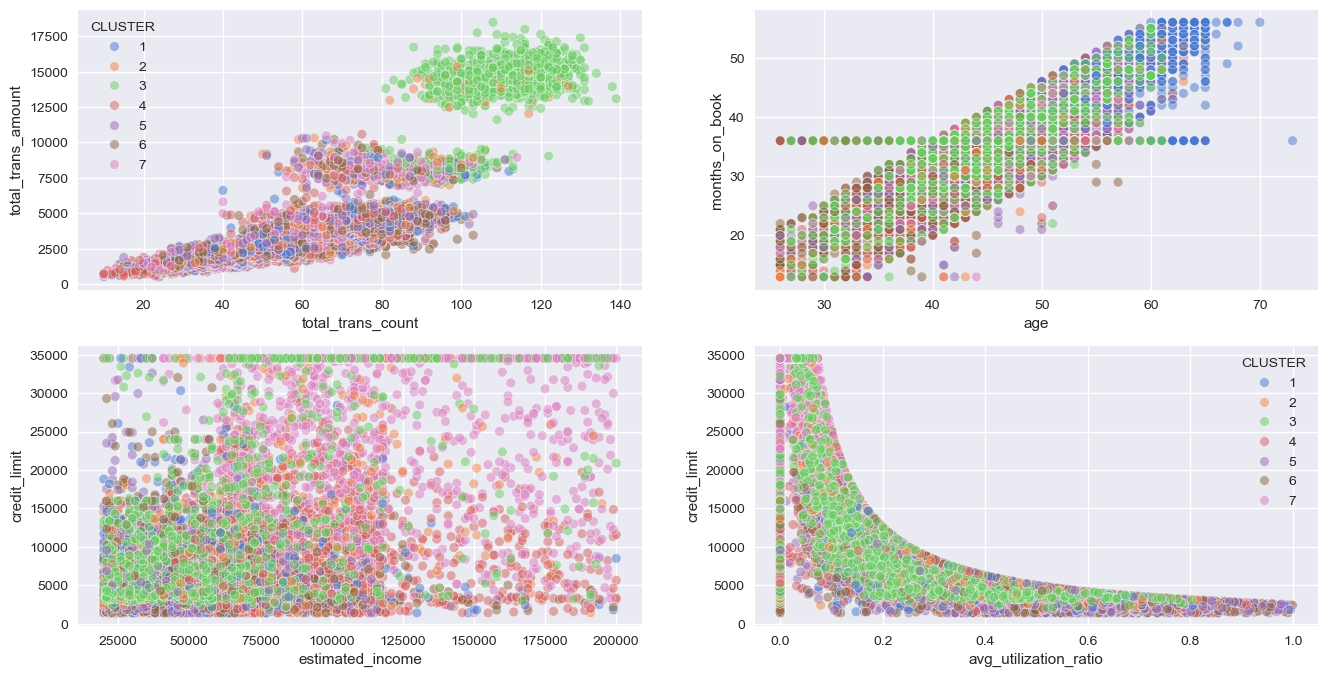

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))

sns.scatterplot(data=data, y='total_trans_amount', x='total_trans_count', hue='CLUSTER', palette='muted', alpha=0.5, ax=ax1)
sns.scatterplot(data=data, y='months_on_book', x='age', hue='CLUSTER', palette='muted', alpha=0.5, legend=False, ax=ax2)
sns.scatterplot(data=data, y='credit_limit', x='estimated_income', hue='CLUSTER', palette='muted', alpha=0.5, legend=False, ax=ax3)
sns.scatterplot(data=data, y='credit_limit', x='avg_utilization_ratio', hue='CLUSTER', palette='muted', alpha=0.5, ax=ax4)
plt.show()

Some early conclusions we can draw are that cluster 3 is composed of customers with many transactions, cluster 1 is mainly older customers, and cluster 5 is mostly customers at the lower range of the credit limit.

Finally, let's look at the categorical columns. We'll plot the percentual distribution of each variable per cluster to identify patterns:

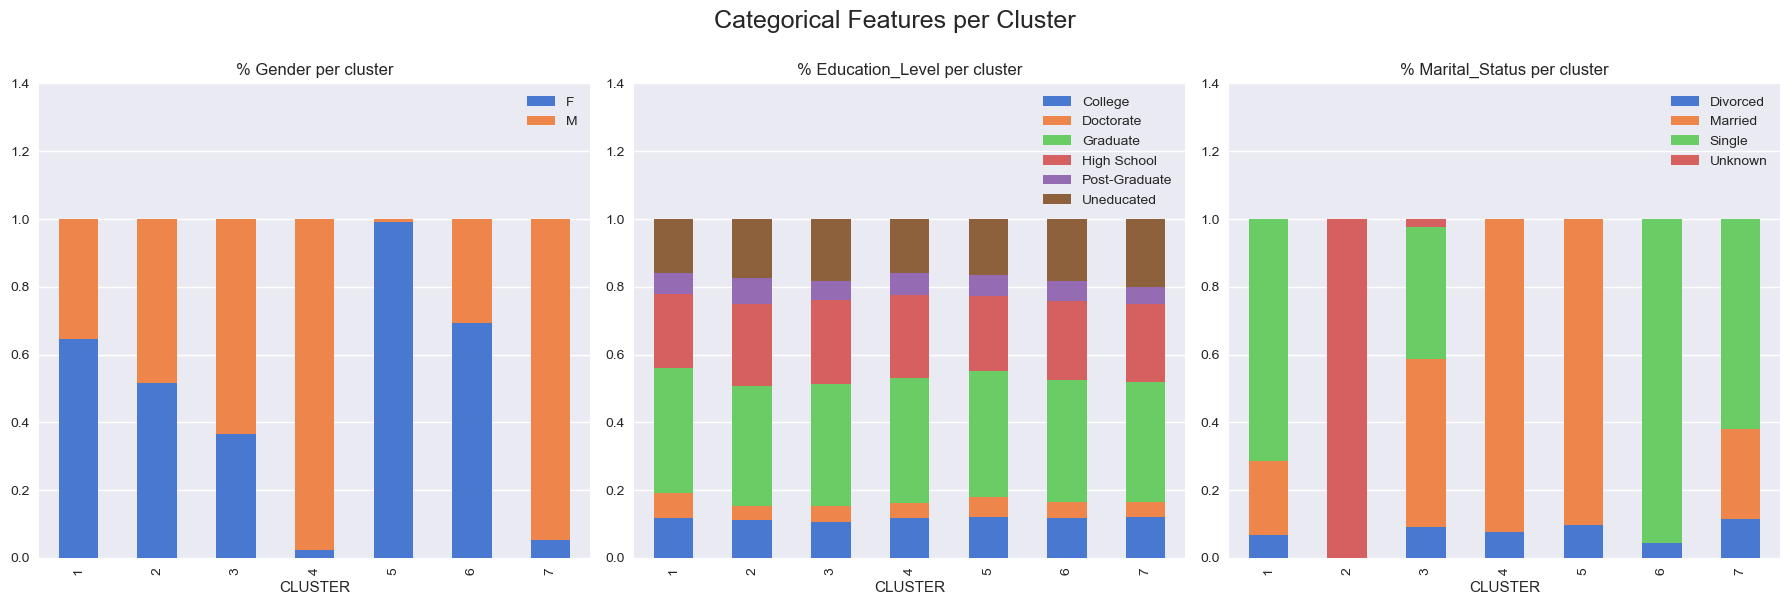

In [59]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Categorical Features per Cluster", fontsize=18, y=1.0)

for i, col in enumerate(categorical_features):
    plot_df = pd.crosstab(index=data['CLUSTER'], columns=data[col], values=data[col], aggfunc='size', normalize='index')

    ax = plt.subplot(1, 3, i + 1)
    plot_df.plot.bar(stacked=True, ax=ax, color=sns.color_palette('muted'))
    ax.set_title(f"% {col.title()} per cluster")

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)

    labels = ['0%', '20%', '40%', '60%', '80%', '100%']
    #ax.set_yticklabels(labels)
    
plt.tight_layout()
plt.show()

Based on the data visualizations, we can make the following observations about the customer clusters:

* Clusters 4 and 7 are predominantly composed of male customers, while cluster 5 has a majority of female customers
* The marital status distribution varies significantly across the clusters. Clusters 4 and 5 are composed primarily of married customers, clusters 1 and 6 have mostly single customers, and cluster 2 lacks information on the marital status of its customers
* The education level distribution remains relatively consistent across the different customer clusters

## Conclusion <a name="conclusion"></a>
The analysis of the customer data has revealed distinct characteristics and insights for each identified cluster:

### Cluster 1
**Characteristics**:  Approximately 65% female, 70% single customers, with higher ages, low dependents, medium-low incomes and credit limits, but high utilization ratios.

**Insight**: This cluster seems to comprise older, financially-strained customers who have been loyal to the company for an extended period. Tailored products and services to improve their financial well-being could be impactful.

### Cluster 2
**Characteristics**: Customers with unknown marital status, exhibiting medium values across most features and a medium-high utilization ratio.

**Insight**: This small cluster represents customers for whom we lack critical demographic information. Further investigation into this group could uncover valuable insights to enhance our understanding of their needs and behaviors.

### Cluster 3
**Characteristics**: Predominantly male customers with good credit limits, very high transaction volumes and amounts, but low relationship counts.

**Insight**: These appear to be highly engaged, high-spending customers who heavily utilize our credit card services. Retaining their loyalty should be a priority.

### Cluster 4
**Characteristics**: Predominantly married, male customers with high incomes, relationship counts, but low transaction volumes and amounts.

**Insight**:  This cluster's behavior is counterintuitive, as their financial capacity suggests they should be higher-spending customers. Deeper analysis is warranted to understand the underlying reasons for their relatively low card usage. This could uncover valuable insights to shape more tailored products and services that align with their specific needs and preferences.

### Cluster 5
**Characteristics**: Mostly married female customers with low incomes, low credit limits, and high utilization ratios.

**Insight**: This cluster represents financially constrained, low-income married women who could benefit from tools and resources to better manage their finances.

### Cluster 6
**Characteristics**: Mostly single female customers with low incomes and credit limits, and high utilization ratios.

**Insight**: This cluster shares similarities with Cluster 2, consisting of financially-constrained single women. Providing targeted financial education and management tools could benefit this segment.

### Cluster 7
**Characteristics**: Predominantly single, male customers with very high incomes and credit limits, but relatively low transaction volumes and amounts.

**Insight**: These wealthy, single men appear to underutilize our credit card services. Identifying ways to increase their engagement and spending could be a valuable opportunity. On the other hand, their relatively low transaction volumes and amounts may indicate they have sufficient alternative financial resources and services that meet their needs. Rather than aggressively trying to increase their usage of our products, a more prudent approach could be to understand their preferences and pain points, and ensure we are providing compelling value propositions that align with their financial management strategies.

## Next Steps <a name="next_steps"></a>

This conculed the initial analysis of our data. Potential next steps are:
* Gathering additional data to better undersatnd the customers that comprise cluster 4
* Build a model that uses fewer variables and see if it can still provide a good clusterisation
* Experiment with different numbers of clusters, e.g., based on our marketing team's capacity